In [1]:
# Imports

import os
import random

import imageio.v2 as imageio
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage import io

import typing as ty
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
import torchmetrics

import neptune.new as neptune

import onnx
import onnxruntime as rt

In [2]:
# Check if PyTorch has GPU available
print('Pytorch GPU Available:', torch.cuda.is_available())

Pytorch GPU Available: True


In [3]:
# Global Configurations
PROJECT_PATH = 'D:\Documents\Kiwibot\depth-estimation-project'
USEFUL_CAMERAS = [['/video_mapping/left', '/video_mapping/left/depth_map'],
                  ['/video_mapping/right', '/video_mapping/right/depth_map'],
                  ['/video_mapping/back', '/video_mapping/back/depth_map'],
                  ['/camera/color/image_raw', '/camera/color/image_raw/depth_map']]
NEPTUNE_TOKEN = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMDQ1OWE3Yy0zMzA3LTQzY2ItYmFlOS02YzRjZGY3NGRlZmMifQ=="

## Metrics

For the evaluation of models, the following evaluation metrics were chosen:
* Absolute relative difference (MAE)
* Root Mean Squared Log Error (RMSLE)
* Prediction Time

## Data Pipeline

In [4]:
# Data examination

metadata_path = os.path.join(PROJECT_PATH, 'data', 'metadata.csv')
metadata = pd.read_csv(metadata_path, encoding='utf-8')
metadata.head()

,/video_mapping/left,/video_mapping/right,/camera/color/image_raw,/video_mapping/back,pos_x,pos_y,pos_z,quat_x,quat_y,quat_z,...,timestamp,/video_mapping/back/depth_map,/video_mapping/right/depth_map,/video_mapping/left/depth_map,/camera/color/image_raw/depth_map,lat,lon,roll,pitch,yaw
0,video_mapping_left_image_1642547234833.jpg,video_mapping_right_image_1642547234915.jpg,camera_color_image_raw_image_1642547234869.jpg,video_mapping_back_image_1642547234852.jpg,-62.572842,-223.608342,0.0,-0.016309,0.001048,0.375159,...,1642547234874,video_mapping_back_depth_map_1642547234874.png,video_mapping_right_depth_map_1642547234874.png,video_mapping_left_depth_map_1642547234874.png,camera_color_image_raw_depth_map_1642547234874...,NaN,NaN,NaN,NaN,NaN
1,video_mapping_left_image_1642547235194.jpg,video_mapping_right_image_1642547235169.jpg,camera_color_image_raw_image_1642547235135.jpg,video_mapping_back_image_1642547235234.jpg,-62.572842,-223.608342,0.0,-0.016309,0.001048,0.375159,...,1642547235189,video_mapping_back_depth_map_1642547235189.png,video_mapping_right_depth_map_1642547235189.png,video_mapping_left_depth_map_1642547235189.png,camera_color_image_raw_depth_map_1642547235189...,33.969986,-118.416718,-0.009817,-0.094902,0.769036
2,video_mapping_left_image_1642547235565.jpg,video_mapping_right_image_1642547235538.jpg,camera_color_image_raw_image_1642547235469.jpg,video_mapping_back_image_1642547235473.jpg,-62.572842,-223.608342,0.0,-0.016309,0.001048,0.375159,...,1642547235515,video_mapping_back_depth_map_1642547235515.png,video_mapping_right_depth_map_1642547235515.png,video_mapping_left_depth_map_1642547235515.png,camera_color_image_raw_depth_map_1642547235515...,33.969986,-118.416718,-0.009817,-0.094902,0.769036
3,video_mapping_left_image_1642547236192.jpg,video_mapping_right_image_1642547236156.jpg,camera_color_image_raw_image_1642547236136.jpg,video_mapping_back_image_1642547236227.jpg,-62.572842,-223.608342,0.0,-0.016309,0.001048,0.375159,...,1642547236188,video_mapping_back_depth_map_1642547236188.png,video_mapping_right_depth_map_1642547236188.png,video_mapping_left_depth_map_1642547236188.png,camera_color_image_raw_depth_map_1642547236188...,33.969986,-118.416717,-0.009817,-0.094902,0.769036
4,video_mapping_left_image_1642547236548.jpg,video_mapping_right_image_1642547236535.jpg,camera_color_image_raw_image_1642547236470.jpg,video_mapping_back_image_1642547236453.jpg,-62.572842,-223.608342,0.0,-0.016309,0.001048,0.375159,...,1642547236508,video_mapping_back_depth_map_1642547236508.png,video_mapping_right_depth_map_1642547236508.png,video_mapping_left_depth_map_1642547236508.png,camera_color_image_raw_depth_map_1642547236508...,33.969986,-118.416717,-0.009817,-0.094902,0.769036


## Pytorch Data Pipeline

In [5]:
images_dir = os.path.join(PROJECT_PATH, 'data', 'lidar-cams-dataset')


class LidarDepthDataset(Dataset):

    def __init__(self, csv_file, images_dir,transform=None):

        columns = [item for sublist in USEFUL_CAMERAS for item in sublist] + ['timestamp']

        self.metadata = pd.read_csv(csv_file, encoding='utf-8')
        self.metadata = self.metadata.sort_values(by=['timestamp'])[columns]
        self.images_dir = images_dir
        self.transform = transform

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if type(idx) == int:
            idx = [idx]

        data_len = len(self.metadata) - 3

        idx_np = np.array(idx)
        new_idx = np.empty([len(idx_np), 2], dtype=int)

        new_idx[:, 0] = idx_np // data_len
        new_idx[:, 1] = idx_np % data_len

        img_names = []
        map_names = []

        column_image = 2 * new_idx[0, 0]  # Camera columns are even in dataset
        column_map = 2 * new_idx[0, 0] + 1  # Maps are odds
        row_idx = new_idx[0, 1]

        img_names.append(os.path.join(self.images_dir, self.metadata.iloc[row_idx, column_image]))
        map_names.append(os.path.join(self.images_dir, self.metadata.iloc[row_idx, column_map]))

        img_names.reverse()
        map_names.reverse()

        images_np = np.array([])
        for img_path in img_names:
            image = io.imread(img_path)
            image = image / 255
            images_np = np.vstack([images_np, image]) if images_np.size else image

        depth_maps_np = np.array([])
        for map_path in map_names:
            depth_map = np.array(imageio.imread(map_path)).astype(float)
            depth_maps_np = np.vstack([depth_maps_np, depth_map]) if depth_maps_np.size else depth_map

        sample = {'image': images_np, 'depth_map': depth_maps_np}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return (len(self.metadata) - 3) * 4

In [6]:
dataset = LidarDepthDataset(metadata_path,images_dir)

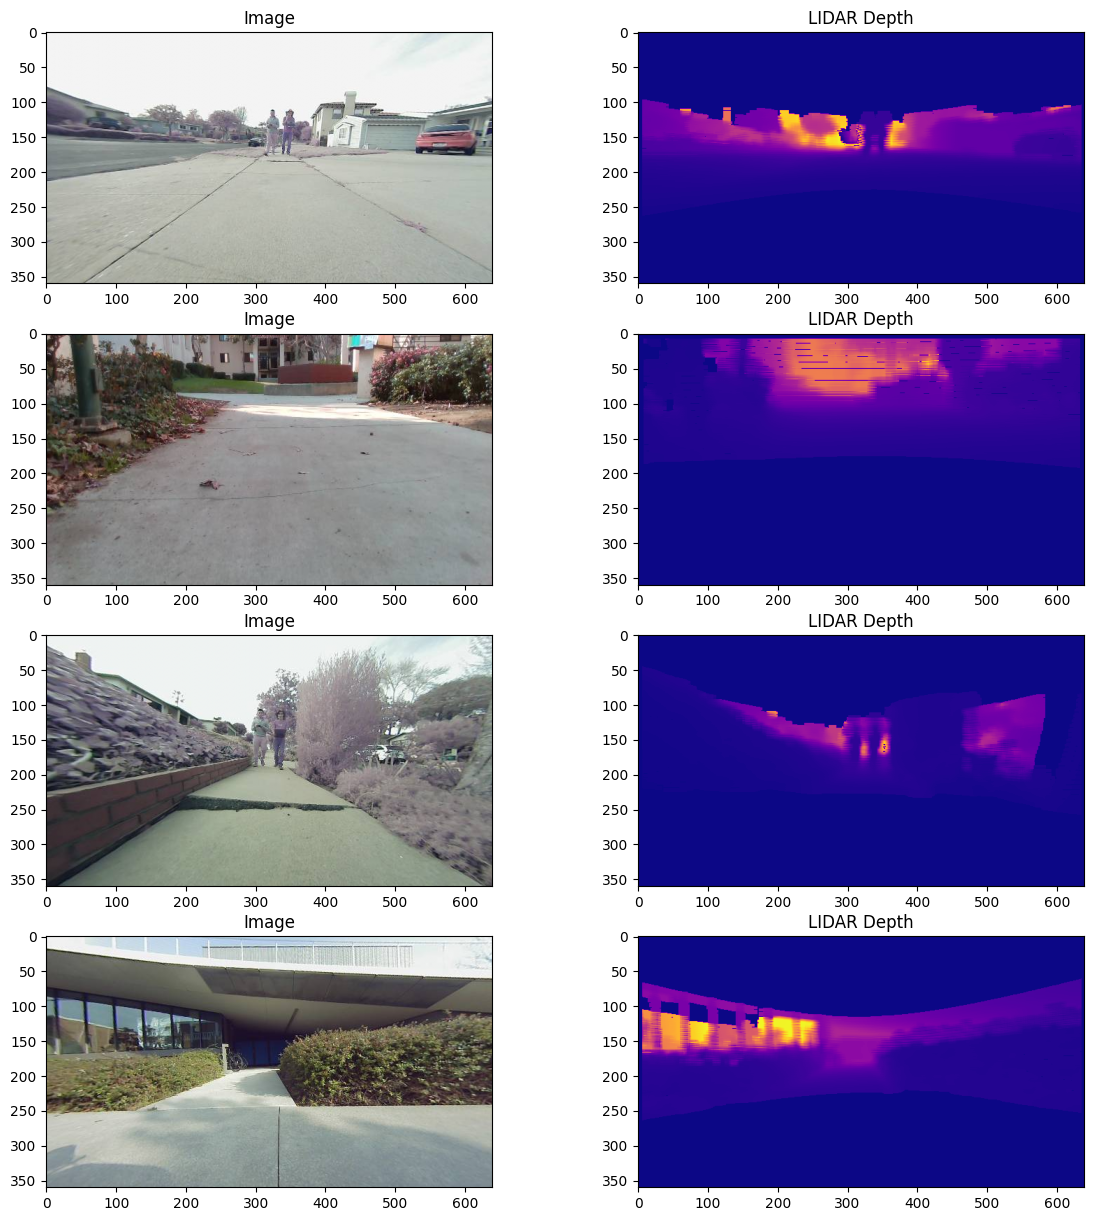

In [7]:
# Check out some images
fig, ax = plt.subplots(4, 2, figsize=(14, 15))

for i in range(4):
    N = random.randint(0, len(dataset))

    sample = dataset.__getitem__(N)
    images = sample['image']
    maps = sample['depth_map']

    ax[i, 0].imshow(images)
    ax[i, 0].set_title('Image')
    ax[i, 1].imshow(maps, cmap='plasma')
    ax[i, 1].set_title('LIDAR Depth')

plt.show()

In [8]:
# Transformations
class Resize(object):
    """Resize sample to given size (width, height).
    """

    def __init__(
            self,
            width,
            height,
            resize_target=True,
            keep_aspect_ratio=False,
            ensure_multiple_of=1,
            resize_method="lower_bound",
            image_interpolation_method=cv2.INTER_AREA,
    ):
        """Init.
        Args:
            width (int): desired output width
            height (int): desired output height
            resize_target (bool, optional):
                True: Resize the full sample (image, depth_map, target).
                False: Resize image only.
                Defaults to True.
            keep_aspect_ratio (bool, optional):
                True: Keep the aspect ratio of the input sample.
                Output sample might not have the given width and height, and
                resize behaviour depends on the parameter 'resize_method'.
                Defaults to False.
            ensure_multiple_of (int, optional):
                Output width and height is constrained to be multiple of this parameter.
                Defaults to 1.
            resize_method (str, optional):
                "lower_bound": Output will be at least as large as the given size.
                "upper_bound": Output will be at max as large as the given size. (Output size might be smaller than given size.)
                "minimal": Scale as least as possible.  (Output size might be smaller than given size.)
                Defaults to "lower_bound".
        """
        self.__width = width
        self.__height = height

        self.__resize_target = resize_target
        self.__keep_aspect_ratio = keep_aspect_ratio
        self.__multiple_of = ensure_multiple_of
        self.__resize_method = resize_method
        self.__image_interpolation_method = image_interpolation_method

    def constrain_to_multiple_of(self, x, min_val=0, max_val=None):
        y = (np.round(x / self.__multiple_of) * self.__multiple_of).astype(int)

        if max_val is not None and y > max_val:
            y = (np.floor(x / self.__multiple_of) * self.__multiple_of).astype(int)

        if y < min_val:
            y = (np.ceil(x / self.__multiple_of) * self.__multiple_of).astype(int)

        return y

    def get_size(self, width, height):
        # determine new height and width
        scale_height = self.__height / height
        scale_width = self.__width / width

        if self.__keep_aspect_ratio:
            if self.__resize_method == "lower_bound":
                # scale such that output size is lower bound
                if scale_width > scale_height:
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            elif self.__resize_method == "upper_bound":
                # scale such that output size is upper bound
                if scale_width < scale_height:
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            elif self.__resize_method == "minimal":
                # scale as least as possbile
                if abs(1 - scale_width) < abs(1 - scale_height):
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            else:
                raise ValueError(
                    f"resize_method {self.__resize_method} not implemented"
                )

        if self.__resize_method == "lower_bound":
            new_height = self.constrain_to_multiple_of(
                scale_height * height, min_val=self.__height
            )
            new_width = self.constrain_to_multiple_of(
                scale_width * width, min_val=self.__width
            )
        elif self.__resize_method == "upper_bound":
            new_height = self.constrain_to_multiple_of(
                scale_height * height, max_val=self.__height
            )
            new_width = self.constrain_to_multiple_of(
                scale_width * width, max_val=self.__width
            )
        elif self.__resize_method == "minimal":
            new_height = self.constrain_to_multiple_of(scale_height * height)
            new_width = self.constrain_to_multiple_of(scale_width * width)
        else:
            raise ValueError(f"resize_method {self.__resize_method} not implemented")

        return (new_width, new_height)

    def __call__(self, sample):
        width, height = self.get_size(
            sample["image"].shape[1], sample["image"].shape[0]
        )

        # resize sample
        sample["image"] = cv2.resize(
            sample["image"],
            (width, height),
            interpolation=self.__image_interpolation_method,
        )

        if self.__resize_target:

            if "depth_map" in sample:
                sample["depth_map"] = cv2.resize(
                    sample["depth_map"], (width, height), interpolation=cv2.INTER_NEAREST
                )

        return sample

class PrepareForNet(object):
    """Prepare sample for usage as network input.
    """

    def __call__(self, sample):
        image = np.transpose(sample["image"], (2, 0, 1))
        sample["image"] = torch.from_numpy(np.ascontiguousarray(image).astype(np.float32))


        if "depth_map" in sample:
            depth = sample["depth_map"].astype(np.float32)
            sample["depth_map"] = torch.from_numpy(np.ascontiguousarray(depth))

        return sample

In [9]:
class ApplyMask(object):
    """Get depth mask and image of the same size for usage as network input.
    """

    def __call__(self, sample):
        image, depth_map = sample['image'], sample['depth_map']
        mask = np.zeros_like(depth_map)
        mask[depth_map>0] = 1
        mask_3 = np.stack((mask,mask,mask),axis=2)
        new_image = image*mask_3

        return {'image': new_image,
                'depth_map':depth_map}

class NormalizeImage(object):
    """Normlize image by given mean and std.
    """

    def __init__(self, mean, std):
        self.__mean = mean
        self.__std = std

    def __call__(self, sample):
        sample["image"] = (sample["image"] - self.__mean) / self.__std

        return sample


In [10]:
transformed_dataset = LidarDepthDataset(metadata_path,images_dir, transform=transforms.Compose([
    Resize(256,256),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ApplyMask(),
    PrepareForNet(),
]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


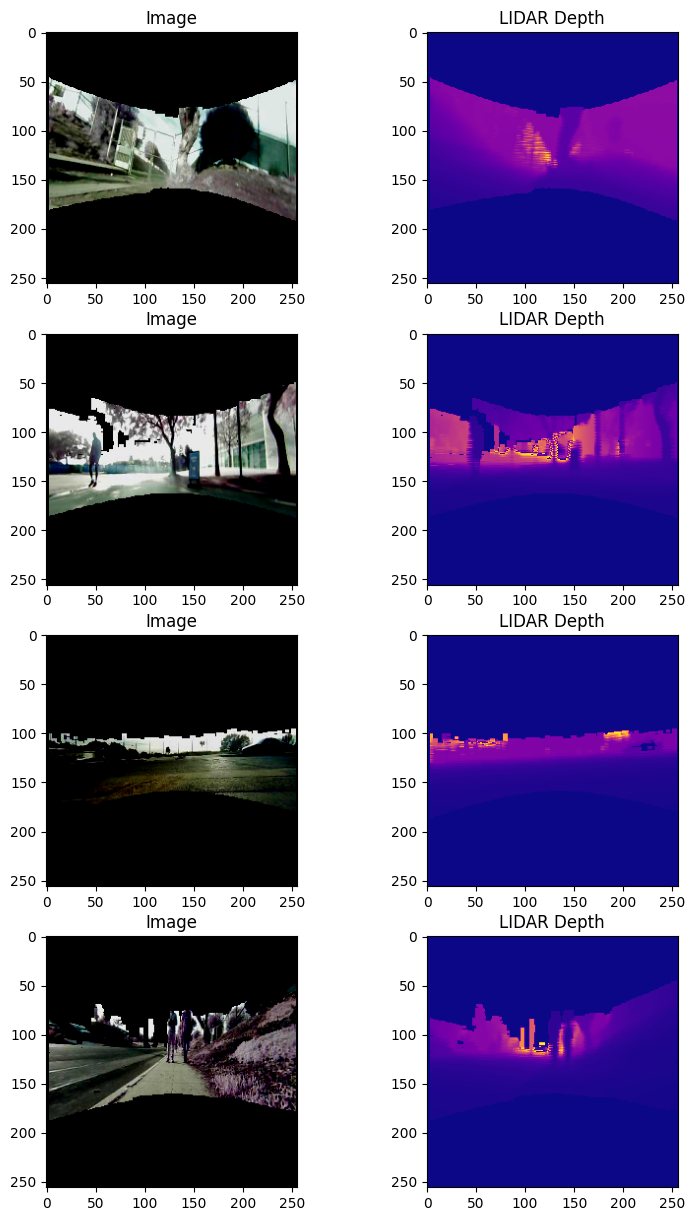

In [11]:
# Check out some images
fig, ax = plt.subplots(4, 2, figsize=(9, 15))

for i in range(4):
    N = random.randint(0, len(dataset))

    sample = transformed_dataset.__getitem__(N)
    images = sample['image']
    maps = sample['depth_map']

    ax[i, 0].imshow(images.permute(1, 2, 0))
    ax[i, 0].set_title('Image')
    ax[i, 1].imshow(maps, cmap='plasma')
    ax[i, 1].set_title('LIDAR Depth')

plt.show()

In [12]:
train_set, val_set, test_set = torch.utils.data.random_split(transformed_dataset, [70000, 3162,3162])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

## MiDaS Model

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
midas_model = torch.hub.load("intel-isl/MiDaS", 'MiDaS_small').to(device)

Using cache found in C:\Users\User/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\User/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


In [15]:
summary(midas_model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
  Conv2dSameExport-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
          Identity-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 24, 128, 128]             768
       BatchNorm2d-9         [-1, 24, 128, 128]              48
         Identity-10         [-1, 24, 128, 128]               0
DepthwiseSeparableConv-11         [-1, 24, 128, 128]               0
           Conv2d-12        [-1, 144, 128, 128]           3,456
      BatchNorm2d-13        [-1, 144, 128, 128]             288
            ReLU6-14        [-1, 1

In [16]:
# Testing forward
midas_pred_transforms = transforms.Compose([
    Resize(256,256),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #ApplyMask(),
    PrepareForNet(),
])

pre_dataset = LidarDepthDataset(metadata_path,images_dir, transform=midas_pred_transforms)
pre_loader = DataLoader(pre_dataset, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


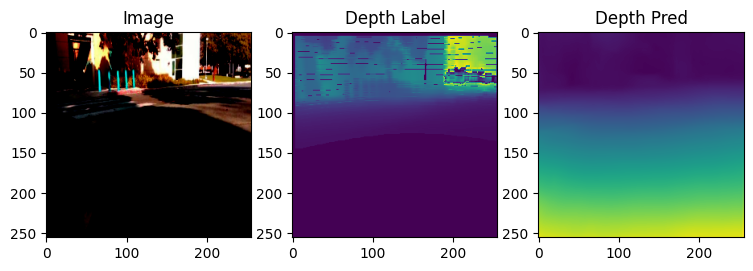

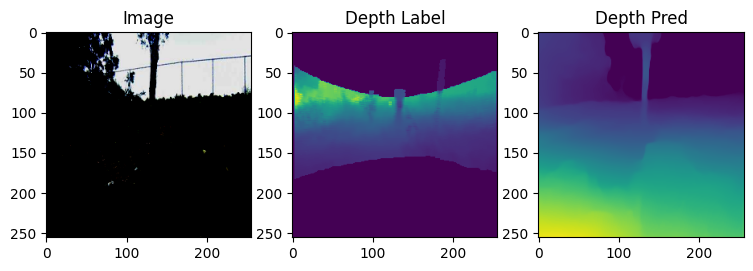

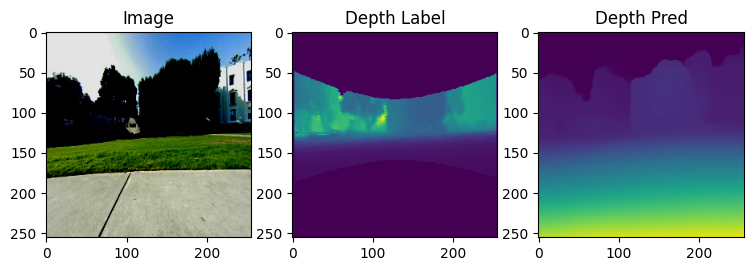

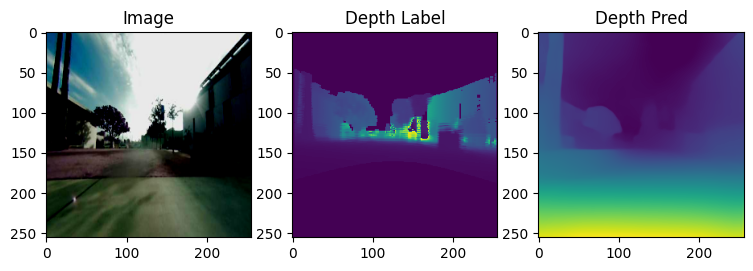

In [17]:
# Inspect before fine-tuning
with torch.no_grad():
    sample = next(iter(pre_loader))
    images = sample['image'].to(device)
    prediction = midas_model(images)

for i in range(4):
    fig, arr = plt.subplots(1, 3, figsize=(9, 15))
    arr[0].imshow(sample['image'][i].permute(1, 2, 0))
    arr[0].set_title('Image')
    arr[1].imshow(sample['depth_map'][i])
    arr[1].set_title('Depth Label')
    arr[2].imshow(prediction[i].cpu())
    arr[2].set_title('Depth Pred')

In [18]:
# Loss function and optimizer

def compute_scale_and_shift(prediction, target, mask):
    # system matrix: A = [[a_00, a_01], [a_10, a_11]]
    a_00 = torch.sum(mask * prediction * prediction, (1, 2))
    a_01 = torch.sum(mask * prediction, (1, 2))
    a_11 = torch.sum(mask, (1, 2))

    # right hand side: b = [b_0, b_1]
    b_0 = torch.sum(mask * prediction * target, (1, 2))
    b_1 = torch.sum(mask * target, (1, 2))

    # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
    x_0 = torch.zeros_like(b_0)
    x_1 = torch.zeros_like(b_1)

    det = a_00 * a_11 - a_01 * a_01
    valid = det.nonzero()

    x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
    x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

    return x_0, x_1


def reduction_batch_based(image_loss, M):
    # average of all valid pixels of the batch

    # avoid division by 0 (if sum(M) = sum(sum(mask)) = 0: sum(image_loss) = 0)
    divisor = torch.sum(M)

    if divisor == 0:
        return 0
    else:
        return torch.sum(image_loss) / divisor


def reduction_image_based(image_loss, M):
    # mean of average of valid pixels of an image

    # avoid division by 0 (if M = sum(mask) = 0: image_loss = 0)
    valid = M.nonzero()

    image_loss[valid] = image_loss[valid] / M[valid]

    return torch.mean(image_loss)


def mse_loss(prediction, target, mask, reduction=reduction_batch_based):

    M = torch.sum(mask, (1, 2))
    res = prediction - target
    image_loss = torch.sum(mask * res * res, (1, 2))

    return reduction(image_loss, 2 * M)


def gradient_loss(prediction, target, mask, reduction=reduction_batch_based):

    M = torch.sum(mask, (1, 2))

    diff = prediction - target
    diff = torch.mul(mask, diff)

    grad_x = torch.abs(diff[:, :, 1:] - diff[:, :, :-1])
    mask_x = torch.mul(mask[:, :, 1:], mask[:, :, :-1])
    grad_x = torch.mul(mask_x, grad_x)

    grad_y = torch.abs(diff[:, 1:, :] - diff[:, :-1, :])
    mask_y = torch.mul(mask[:, 1:, :], mask[:, :-1, :])
    grad_y = torch.mul(mask_y, grad_y)

    image_loss = torch.sum(grad_x, (1, 2)) + torch.sum(grad_y, (1, 2))

    return reduction(image_loss, M)


class MSELoss(nn.Module):
    def __init__(self, reduction='batch-based'):
        super().__init__()

        if reduction == 'batch-based':
            self.__reduction = reduction_batch_based
        else:
            self.__reduction = reduction_image_based

    def forward(self, prediction, target, mask):
        return mse_loss(prediction, target, mask, reduction=self.__reduction)


class GradientLoss(nn.Module):
    def __init__(self, scales=4, reduction='batch-based'):
        super().__init__()

        if reduction == 'batch-based':
            self.__reduction = reduction_batch_based
        else:
            self.__reduction = reduction_image_based

        self.__scales = scales

    def forward(self, prediction, target, mask):
        total = 0

        for scale in range(self.__scales):
            step = pow(2, scale)

            total += gradient_loss(prediction[:, ::step, ::step], target[:, ::step, ::step],
                                   mask[:, ::step, ::step], reduction=self.__reduction)

        return total


class ScaleAndShiftInvariantLoss(nn.Module):
    def __init__(self, alpha=0.5, scales=4, reduction='batch-based'):
        super().__init__()

        self.__data_loss = MSELoss(reduction=reduction)
        self.__regularization_loss = GradientLoss(scales=scales, reduction=reduction)
        self.__alpha = alpha

        self.__prediction_ssi = None

    def forward(self, prediction, target):
        mask = target >= 0
        scale, shift = compute_scale_and_shift(prediction, target, mask)
        self.__prediction_ssi = scale.view(-1, 1, 1) * prediction + shift.view(-1, 1, 1)

        total = self.__data_loss(self.__prediction_ssi, target, mask)
        if self.__alpha > 0:
            total += self.__alpha * self.__regularization_loss(self.__prediction_ssi, target, mask)

        return total

    def __get_prediction_ssi(self):
        return self.__prediction_ssi

    prediction_ssi = property(__get_prediction_ssi)

In [19]:
INIT_LR = 5e-5
opt = torch.optim.Adam(midas_model.parameters(), lr=INIT_LR)
criterion = ScaleAndShiftInvariantLoss()

In [20]:
# Metrics
class RootMeanAbsoluteSquaredError(torchmetrics.Metric):
    def __init__(self):
        super().__init__()
        self.add_state("total", default=torch.tensor(0))

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape

        msle = torchmetrics.functional.mean_squared_log_error(preds,target)
        self.total = torch.sqrt(msle)

    def compute(self):
        return self.total

    full_state_update: bool = True

mae = torchmetrics.MeanAbsoluteError()
rmsle = RootMeanAbsoluteSquaredError()

In [21]:
run = neptune.init(
    project="jushernandezre/depth-estimation",
    api_token=NEPTUNE_TOKEN,
)

https://app.neptune.ai/jushernandezre/depth-estimation/e/DEP-46
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [26]:
def save_network(model, optimizer, loss, epoch_label, device):
    save_filename = 'net_%s.pth' % epoch_label
    save_path = os.path.join(PROJECT_PATH,'models','custom-formats', save_filename)
    torch.save(model.cpu().state_dict(), save_path)

    torch.save({
        'epoch': epoch_label,
        'model_state_dict': model.cpu().state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, save_path)

    model.to(device)

In [27]:
def train_step(
        model: nn.Module,
        criterion: nn.Module,
        optimizer: torch.optim.Optimizer,
        batch: ty.List[torch.Tensor],
        device: torch.device = None
) -> ty.Tuple[torch.Tensor, torch.Tensor]:
    """Training step.
    Args:
        model: model to train
        criterion: loss function
        optimizer: optimizer
        batch: batch of data
        device: device to use
    Returns:
        loss: loss value
        outputs: model outputs
    """
    inputs, labels = batch['image'], batch['depth_map']

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    return loss, outputs


@torch.no_grad()
def eval_step(
        model: nn.Module,
        criterion: nn.Module,
        batch: ty.List[torch.Tensor],
        device: torch.device = None,
) -> ty.Tuple[torch.Tensor, torch.Tensor]:
    """Evaluation step.
    Args:
        model: model to evaluate
        criterion: loss function
        batch: batch of data
        device: device to use
    Returns:
        loss: loss value
        outputs: model outputs
    """
    inputs, labels = batch['image'], batch['depth_map']

    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    return loss, outputs


def train(
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        criterion: nn.Module,
        optimizer: torch.optim.Optimizer,
        device: torch.device,
        n_epoch: int = 10,
        metrics: ty.List[torchmetrics.Metric] = [],
        val_metrics: ty.List[torchmetrics.Metric] = [],
        run = False
):
    """Train and evaluate the model given the train and eval dataloaders,
    loss function, optimizer, device, and number of epochs and metrics.
    Args:
        model: nn.Module
            model to train
        train_loader: data.DataLoader
            train dataloader
        val_loader: data.DataLoader
            validation dataloader
        criterion: nn.Module
            loss function
        optimizer: torch.optim.Optimizer
            optimizer
        device: torch.device
            device to use
        n_epoch: int
            number of epochs to train for
        metrics: ty.List[torchmetrics.Metric]
            list of metrics to track
        val_metrics: ty.List[torchmetrics.Metric]
            list of metrics to track on validation set
    """

    if run:
        run["config/model"] = type(model).__name__
        run["config/criterion"] = type(criterion).__name__
        run["config/optimizer"] = type(optimizer).__name__

    for epoch in tqdm(range(n_epoch), total=n_epoch, desc="Epoch: "):
        train_loss = 0.0
        train_steps = 0
        if run:
            run['training/train/epoch/epoch'].log(epoch)

        model.train()
        for batch in tqdm(train_loader, total=len(train_loader), desc="Step: "):
            loss, outputs = train_step(model, criterion, optimizer, batch, device)
            train_loss += loss.item()
            train_steps += 1
            if run:
                run['training/train/batch/loss'].log(loss)
                run['training/train/epoch/steps'].log(train_steps)

            # call metrics
            outputs = outputs.to("cpu")
            for metric in metrics:
                metric.update(outputs, batch['depth_map'])
                if run:
                    run['training/train/batch/'+str(metric)].log(metric.compute())


        train_loss /= train_steps
        if run:
            run['training/train/epoch/loss'].log(train_loss)

        val_loss = 0.0
        val_steps = 0
        model.eval()
        for batch in val_loader:
            loss, outputs = eval_step(model, criterion, batch, device)
            val_loss += loss.item()
            val_steps += 1
            if run:
                run['training/valid/batch/loss'].log(val_loss)
                run['training/valid/epoch/steps'].log(val_steps)

            # call metrics
            outputs = outputs.to("cpu")
            for metric in val_metrics:
                metric.update(outputs, batch['depth_map'])
                if run:
                    run['training/valid/batch/'+str(metric)].log(metric.compute())

        val_loss /= val_steps

        if run:
            run['training/valid/epoch/loss'].log(val_loss)
        print(
            f"[{epoch + 1:03d}] train loss: {train_loss:.3f}, val loss: {val_loss:.3f}"
        )

        # Train metrics
        if metrics:
            msg = f"[{epoch + 1:03d}] "
            for metric in metrics:
                score = metric.compute()
                msg += f"train {metric.__class__.__name__}: {score} "
                if run:
                    run['training/train/epoch/'+str(metric)].log(metric.compute())
            print(msg)
        # Eval metrics
        if val_metrics:
            msg = f"[{epoch + 1:03d}] "
            for metric in val_metrics:
                score = metric.compute()
                msg += f"val {metric.__class__.__name__}: {score} "
                if run:
                    run['training/valid/epoch/'+str(metric)].log(metric.compute())
            print(msg)

        print('Saving model...')
        try:
            save_network(model, optimizer, train_loss, epoch, device)
            print('Model saved!')
        except:
            print('Something happened, could not save model')

        print("-" * 40)

In [ ]:
# If need to freeze parameters
# model_conv = torchvision.models.resnet18(pretrained=True)
# for param in model_conv.parameters():
#     param.requires_grad = False

In [ ]:
train(
    midas_model,
    train_loader,
    val_loader,
    criterion,
    opt,
    device,
    n_epoch=9,
    metrics=[mae,rmsle],
    val_metrics=[mae,rmsle],
    run=run
)

In [36]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/jushernandezre/depth-estimation/e/DEP-46


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


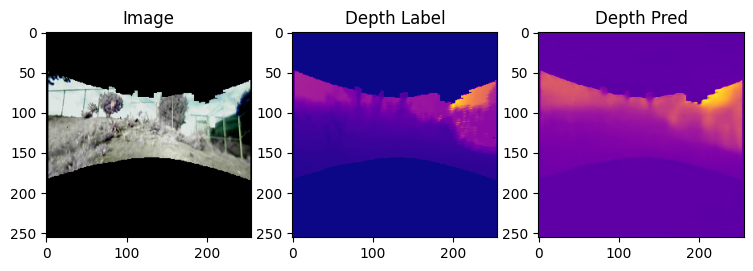

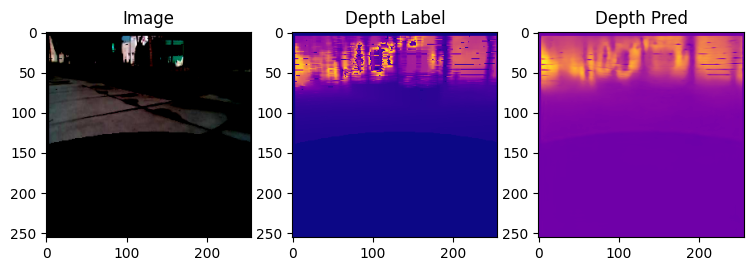

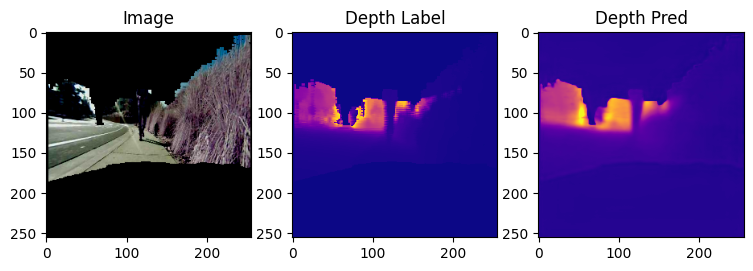

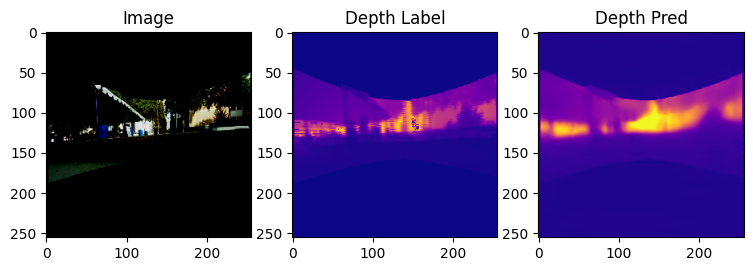

In [43]:
# Inspect before fine-tuning
with torch.no_grad():
    sample = next(iter(test_loader))
    images = sample['image'].to(device)
    prediction = midas_model(images)

for i in range(4):
    fig, arr = plt.subplots(1, 3, figsize=(9, 15))
    arr[0].imshow(sample['image'][i].permute(1, 2, 0))
    arr[0].set_title('Image')
    arr[1].imshow(sample['depth_map'][i], cmap='plasma')
    arr[1].set_title('Depth Label')
    arr[2].imshow(prediction[i].cpu(), cmap='plasma_r')
    arr[2].set_title('Depth Pred')

In [54]:
# Export the model in ONNX format
midas_model_export = midas_model.cpu()

# Input to the model
input_onnx = sample['image']
output_onnx = midas_model_export(input_onnx)

# Save the model in ONNX

torch.onnx.export(midas_model_export,               # model being run
                  input_onnx,                         # model input (or a tuple for multiple inputs)
                  "D:\Documents\Kiwibot\depth-estimation-project\models\ONNX\midas.onnx",   # where to save the model
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=13,          # the ONNX version to export the model to
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [55]:
# Save the model
torch.save(
    midas_model_export.state_dict(),
    'D:\\Documents\\Kiwibot\\depth-estimation-project\\models\\custom-formats\\midas.pth'
)

## Prediction

In [56]:
model_file_path = os.path.join(PROJECT_PATH,'models','ONNX','midas.onnx')

In [67]:
onnx_transforms = transforms.Compose([
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    lambda sample: {'image': np.transpose(sample["image"], (2, 0, 1))}
])

In [57]:
input_images_camera = [x[0] for x in USEFUL_CAMERAS]
images_paths = metadata[input_images_camera]

test_images_paths = []
N = random.randint(0,images_paths.shape[0])
for i in range(images_paths.shape[1]):
    test_images_paths.append(os.path.join(PROJECT_PATH,'data','lidar-cams-dataset',images_paths[input_images_camera[i]][N]))

In [77]:
input_images = np.zeros((4,256,256,3),dtype=np.float32)
test_images = np.zeros((4,3,256,256),dtype=np.float32)

for i, image_path in enumerate(test_images_paths):
    img = cv2.imread(image_path)[:,:,::-1]
    img_resized = cv2.resize(img,(256,256),cv2.INTER_CUBIC)
    img_scaled = img_resized/255
    img_norm = onnx_transforms({'image': img_scaled})['image']
    test_images[i] = img_norm
    input_images[i] = img_scaled

In [ ]:
torch.cuda.empty_cache()

In [80]:
providers = ['CUDAExecutionProvider']
sess = rt.InferenceSession(model_file_path, providers=providers)

In [ ]:
%%time
onnx_pred = sess.run(None, {"input": test_images})

In [84]:
onnx_pred_np  = np.array(onnx_pred).squeeze()

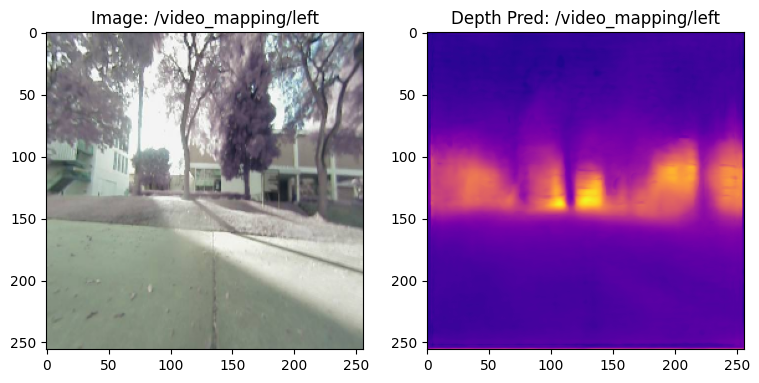

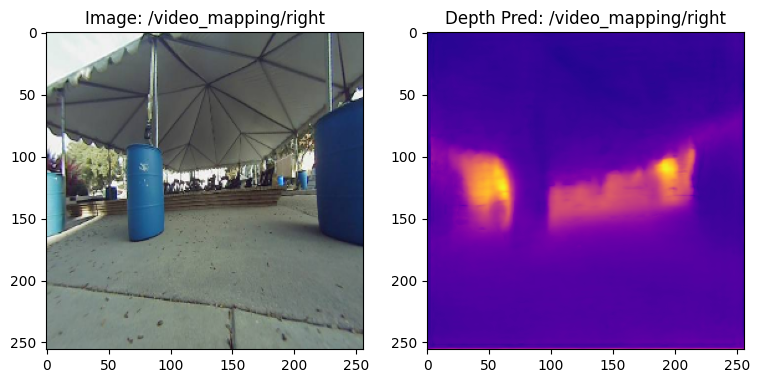

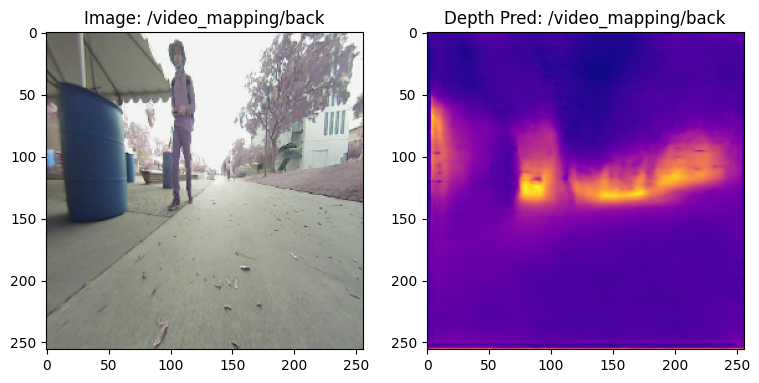

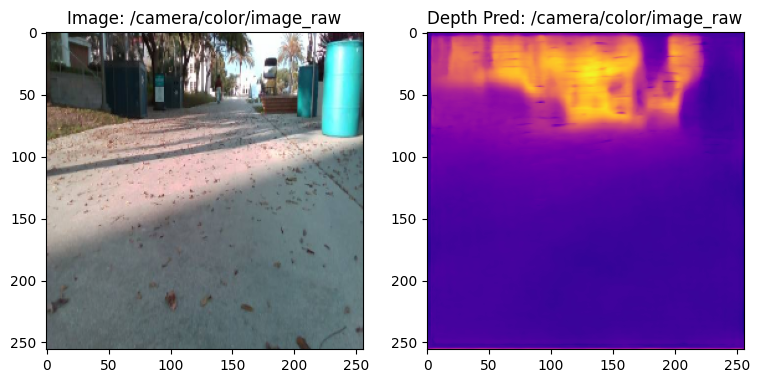

In [88]:
for i,camera in enumerate(input_images_camera):
    fig, arr = plt.subplots(1, 2, figsize=(9, 15))
    arr[0].imshow(input_images[i].astype(float))
    arr[0].set_title(f'Image: {camera}')
    arr[1].imshow(onnx_pred_np[i], cmap='plasma_r')
    arr[1].set_title(f'Depth Pred: {camera}')

## References
* [Monocular Depth Estimation Using Deep Learning: A Review](https://www.mdpi.com/1424-8220/22/14/5353/pdf?version=1658138962)
* [Depth Estimation - Papers with code](https://paperswithcode.com/task/depth-estimation)
* [Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer - Code](https://github.com/isl-org/MiDaS)
* [Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer - Paper](https://arxiv.org/abs/1907.01341v3)